# 🧪 Model Testing & Evaluation Notebook

This notebook is dedicated to **testing and evaluating a pre-trained speaker verification model**.

## 📋 Overview

This notebook is separated from training to allow:
1. **Fast iteration** on evaluation without re-running training
2. **Testing different thresholds** for access control
3. **Evaluating on new test sets** without loading training code
4. **Generating reports** for model performance

## 🔄 Workflow

```
┌─────────────────────────────────────────────────────────────────┐
│                    TRAINING NOTEBOOK                             │
│  voice_recognition_rnn_cnn.ipynb                                │
│  ┌──────────┐   ┌──────────┐   ┌──────────────────┐            │
│  │ Dataset  │ → │ Training │ → │ Save Checkpoint  │            │
│  │ (.h5)    │   │ Loop     │   │ (best_model.pt)  │            │
│  └──────────┘   └──────────┘   └──────────────────┘            │
└─────────────────────────────────────────────────────────────────┘
                              ↓
┌─────────────────────────────────────────────────────────────────┐
│                 THIS NOTEBOOK (Testing)                          │
│  ┌──────────────────┐   ┌──────────────────┐   ┌────────────┐  │
│  │ Load Checkpoint  │ → │ Load Test Data   │ → │ Evaluate   │  │
│  │ (best_model.pt)  │   │ (test split)     │   │ & Report   │  │
│  └──────────────────┘   └──────────────────┘   └────────────┘  │
└─────────────────────────────────────────────────────────────────┘
```

## 📁 Required Files

- **Checkpoint**: `checkpoints/trainXX/best_model.pt` (trained model weights)
- **Dataset**: `outputs/logmels_*.h5` (HDF5 file with test split)
- **Model Definitions**: Model classes are re-defined here (or can be imported)

In [71]:
# ============================================================================
# SECTION 1: IMPORTS AND ENVIRONMENT SETUP
# ============================================================================
# Core libraries for model testing and evaluation

import os
import glob
import warnings
import numpy as np
import h5py
import yaml
import time
from datetime import datetime
from collections import defaultdict

import torch
import torch.nn as nn
import torch.nn.functional as F

# Visualization
import matplotlib.pyplot as plt
import seaborn as sns

# Metrics
from sklearn.metrics import (
    classification_report, confusion_matrix, 
    accuracy_score, f1_score, precision_recall_fscore_support
)

warnings.filterwarnings("ignore", category=FutureWarning)

# ============================================================================
# SELECT DATASET AND CHECKPOINT
# ============================================================================
print("="*70)
print("📂 AVAILABLE DATASETS")
print("="*70)

available_datasets = sorted(glob.glob("outputs/logmels_*.h5"), key=os.path.getmtime, reverse=True)
for i, ds in enumerate(available_datasets[:10]):
    size_mb = os.path.getsize(ds) / (1024*1024)
    mtime = datetime.fromtimestamp(os.path.getmtime(ds)).strftime("%Y-%m-%d %H:%M")
    print(f"   {i+1}. {ds} ({size_mb:.1f} MB, {mtime})")

print("\n" + "="*70)
print("📁 AVAILABLE CHECKPOINTS")
print("="*70)

checkpoint_dirs = sorted(glob.glob("checkpoints/train*"), key=os.path.getmtime, reverse=True)
for i, cp in enumerate(checkpoint_dirs[:10]):
    best_path = os.path.join(cp, "best_model.pt")
    exists = "✓" if os.path.exists(best_path) else "✗"
    mtime = datetime.fromtimestamp(os.path.getmtime(cp)).strftime("%Y-%m-%d %H:%M")
    print(f"   {i+1}. {cp} [{exists}] ({mtime})")

# ============================================================================
# ⚠️ CONFIGURE THESE PATHS
# ============================================================================
# Select which dataset and checkpoint to use:
#dataset_path = available_datasets[0] if available_datasets else "outputs/logmels_aug.h5"
#checkpoint_path = os.path.join(checkpoint_dirs[0], "best_model.pt") if checkpoint_dirs else "checkpoints/train1/best_model.pt"

dataset_path = "outputs/logmels_spkid_aug_26-01-25_19-04-46.h5"
checkpoint_path = "checkpoints/train29/best_model.pt"

print(f"\n✅ Selected Dataset: {dataset_path}")
print(f"✅ Selected Checkpoint: {checkpoint_path}")

📂 AVAILABLE DATASETS
   1. outputs\logmels_binary_aug_26-01-26_15-26-21.h5 (712.1 MB, 2026-01-26 15:27)
   2. outputs\logmels_spkid_aug_26-01-25_19-04-46.h5 (839.3 MB, 2026-01-25 19:05)
   3. outputs\logmels_aug_26-01-25_18-05-06.h5 (839.0 MB, 2026-01-25 18:05)
   4. outputs\logmels_aug_26-01-25_17-35-28.h5 (532.3 MB, 2026-01-25 17:36)
   5. outputs\logmels_aug_26-01-25_16-59-42.h5 (532.4 MB, 2026-01-25 17:00)
   6. outputs\logmels_aug_26-01-25_16-31-21.h5 (531.9 MB, 2026-01-25 16:31)
   7. outputs\logmels_aug_26-01-25_16-18-32.h5 (0.0 MB, 2026-01-25 16:18)
   8. outputs\logmels_fixed_split.h5 (857.4 MB, 2026-01-25 11:32)
   9. outputs\logmels_aug_26-01-25_10-04-39.h5 (531.8 MB, 2026-01-25 10:05)
   10. outputs\logmels_aug_26-01-25.h5 (0.0 MB, 2026-01-25 09:51)

📁 AVAILABLE CHECKPOINTS
   1. checkpoints\train31 [✓] (2026-01-26 15:28)
   2. checkpoints\train30 [✓] (2026-01-25 20:06)
   3. checkpoints\train29 [✓] (2026-01-25 19:31)
   4. checkpoints\train28 [✗] (2026-01-25 19:29)
   5. c

## Section 2: Model Architecture Definitions

We need to re-define the model architecture classes here because PyTorch requires them when loading the checkpoint.

**Note**: These classes must match EXACTLY what was used during training!

In [72]:
# ============================================================================
# SECTION 2: MODEL ARCHITECTURE DEFINITIONS
# ============================================================================
# These MUST match the architecture used during training

class SEBlock(nn.Module):
    """Squeeze-and-Excitation block for channel attention."""
    def __init__(self, channels: int, reduction: int = 16):
        super().__init__()
        hidden = max(channels // reduction, 4)
        self.fc = nn.Sequential(
            nn.Linear(channels, hidden, bias=False),
            nn.ReLU(inplace=True),
            nn.Linear(hidden, channels, bias=False),
            nn.Sigmoid()
        )

    def forward(self, x):
        B, C, T, F = x.shape
        s = x.mean(dim=(2, 3))
        w = self.fc(s).view(B, C, 1, 1)
        return x * w


class Backbone(nn.Module):
    """CNN + RNN backbone for speaker embedding extraction."""
    def __init__(self, no_mels, embed_dim, rnn_hidden, rnn_layers, bidir):
        super().__init__()

        self.cnn_block = nn.Sequential(
            nn.Conv2d(1, 32, 3, padding=1),
            nn.BatchNorm2d(32),
            nn.ReLU(),
            SEBlock(32, reduction=8),
            nn.MaxPool2d(kernel_size=(1, 2)),

            nn.Conv2d(32, 64, 3, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(),
            SEBlock(64, reduction=8),
            nn.MaxPool2d(kernel_size=(1, 2)),

            nn.Conv2d(64, 128, 3, padding=1),
            nn.BatchNorm2d(128),
            nn.ReLU(),
            SEBlock(128, reduction=8),
            nn.MaxPool2d(kernel_size=(1, 2)),
        )

        self.rnn_hidden = rnn_hidden
        self.rnn = nn.GRU(
            input_size=128 * (no_mels // 8),
            hidden_size=self.rnn_hidden,
            num_layers=rnn_layers,
            bidirectional=bidir,
            batch_first=True,
            dropout=0.2
        )

        out_dim = (2 if bidir else 1) * rnn_hidden
        self.rnn_ln = nn.LayerNorm(out_dim)

        self.att = nn.Sequential(
            nn.Linear((2 if bidir else 1)*rnn_hidden, 128),
            nn.Tanh(),
            nn.Linear(128, 1)
        )

        self.proj = nn.Sequential(
            nn.Linear(out_dim*2, 256),
            nn.BatchNorm1d(256), nn.ReLU(),
            nn.Linear(256, embed_dim)
        )

    def forward(self, x, lengths=None, mc_dropout=None):
        if mc_dropout is None:
            mc_dropout = self.training
            
        h = self.cnn_block(x)
        if mc_dropout:
            h = F.dropout(h, p=0.3, training=True)
            
        B, C, T, Fp = h.shape
        h = h.permute(0, 2, 1, 3).contiguous().view(B, T, C*Fp)

        if lengths is not None:
            packed = nn.utils.rnn.pack_padded_sequence(h, lengths.cpu(), batch_first=True, enforce_sorted=False)
            packed_out, _ = self.rnn(packed)
            rnn_out, _ = nn.utils.rnn.pad_packed_sequence(packed_out, batch_first=True)
            Tmax = rnn_out.size(1)
            mask = torch.arange(Tmax, device=rnn_out.device).unsqueeze(0).expand(B, Tmax) < lengths.unsqueeze(1)
        else:
            rnn_out, _ = self.rnn(h)
            mask = torch.ones(rnn_out.size(0), rnn_out.size(1), dtype=torch.bool, device=rnn_out.device)

        if mc_dropout:
            rnn_out = F.dropout(rnn_out, p=0.3, training=True)

        rnn_out = self.rnn_ln(rnn_out)

        a = self.att(rnn_out).squeeze(-1)
        a = a.masked_fill(~mask, float('-inf'))
        w = torch.softmax(a, dim=1).unsqueeze(-1)

        mean = torch.sum(w * rnn_out, dim=1)
        var = torch.sum(w * (rnn_out - mean.unsqueeze(1))**2, dim=1)
        std = torch.sqrt(var + 1e-5)
        stats = torch.cat([mean, std], 1)

        if mc_dropout:
            stats = F.dropout(stats, p=0.3, training=True)

        z = self.proj(stats)
        z = F.normalize(z, p=2, dim=1)
        return z


class AAMSoftmax(nn.Module):
    """Additive Angular Margin Softmax for training."""
    def __init__(self, in_features, out_features, s=30.0, m=0.20):
        super().__init__()
        self.s = s
        self.m = m
        self.in_features = in_features
        self.out_features = out_features
        self.weight = nn.Parameter(torch.empty(out_features, in_features))
        nn.init.xavier_uniform_(self.weight)

    def forward(self, emb, labels):
        W = F.normalize(self.weight, dim=1)
        cos_theta = emb @ W.T
        theta = torch.acos(cos_theta.clamp(-1+1e-7, 1-1e-7))
        target_logits = torch.cos(theta + self.m)
        one_hot = F.one_hot(labels, num_classes=W.size(0)).float()
        output = cos_theta * (1 - one_hot) + target_logits * one_hot
        return output * self.s


class SpeakerClassifier(nn.Module):
    """Main model combining backbone with AAMSoftmax head."""
    def __init__(self, backbone, num_speakers, aamsm_scaler, aamsm_margin):
        super().__init__()
        self.backbone = backbone
        self.aamsm = AAMSoftmax(backbone.proj[-1].out_features, num_speakers, aamsm_scaler, aamsm_margin)
        self._inference_prepared = False
        self.score_alpha = nn.Parameter(torch.tensor(1.0))
        self.score_beta = nn.Parameter(torch.tensor(0.0))
        self.bank = None
        self.inference_threshold = 0.5

    def forward(self, x, labels=None, lengths=None):
        emb = self.backbone(x, lengths=lengths, mc_dropout=None)
        if labels is not None:
            logits = self.aamsm(emb, labels)
            return logits, emb
        else:
            return emb

    def eval(self):
        super().eval()
        if not self._inference_prepared:
            with torch.no_grad():
                self.bank = F.normalize(self.aamsm.weight, dim=1)
            self._inference_prepared = True
        return self

    @torch.no_grad()
    def embed(self, x, lengths=None):
        z = self.backbone(x, lengths=lengths)
        return F.normalize(z, dim=1)

    @torch.no_grad()
    def verify_any(self, x, lengths=None, *, threshold=None, bank=None, return_index=False):
        if bank is None:
            if self.bank is None:
                raise RuntimeError('Bank not built. Call model.eval() first!')
            bank = self.bank
        bank = F.normalize(bank, dim=1)

        probe = self.embed(x, lengths=lengths)
        bank = bank.to(probe.device)
        sims = probe @ bank.T
        scores, idx = sims.max(dim=1)

        scores = self.score_alpha * scores + self.score_beta
        thr = self.inference_threshold if threshold is None else threshold
        decisions = scores >= thr

        if return_index:
            return decisions, scores, idx
        return decisions, scores


print("✅ Model architecture classes defined:")
print("   • SEBlock, Backbone, AAMSoftmax, SpeakerClassifier")

✅ Model architecture classes defined:
   • SEBlock, Backbone, AAMSoftmax, SpeakerClassifier


## Section 3: Data Loader for Test Set

Load the test split from the HDF5 dataset using the cached (RAM-based) loader for fast evaluation.

In [73]:
# ============================================================================
# SECTION 3: DATA LOADER SETUP
# ============================================================================
from data_utils import LMDataset, pad_collate
from functools import partial

class CachedLMDataset(LMDataset):
    """Fast RAM-cached dataset loader."""
    
    def __init__(self, *args, **kwargs):
        super().__init__(*args, **kwargs)
        
        print(f"🚀 Loading {self.N} samples ({self.split}) into RAM...")
        start_time = time.perf_counter()
        
        self._ensure_open()
        
        X_all = np.array(self._X[:], dtype=self.dtype)
        Y_all = np.array(self._Y[:]) if self.has_labels else None
        L_all = np.array(self._L[:]) if self.has_lengths else None
        
        if self._h5 is not None:
            self._h5.close()
            self._h5 = None
        
        self.cache = []
        for idx in range(self.N):
            X = X_all[idx]
            if X.ndim != 2:
                raise ValueError(f"Expected 2D logmel, got {X.shape}")
            
            if self.time_dim == "F":
                X = X.T
            
            X = torch.from_numpy(X[None, ...].copy())
            
            y_raw = Y_all[idx] if Y_all is not None else None
            if y_raw is not None and self.label_map is not None:
                y_val = self.label_map.get(int(y_raw), int(y_raw))
            else:
                y_val = int(y_raw) if y_raw is not None else None
            y = torch.tensor(y_val, dtype=torch.long) if y_val is not None else None
            
            t_len = int(L_all[idx]) if L_all is not None else X.shape[1]
            t_len = torch.tensor(t_len, dtype=torch.long)
            
            self.cache.append((X, y, t_len))
        
        load_time = time.perf_counter() - start_time
        print(f"✓ {self.split.upper()}: {self.N} samples loaded in {load_time:.1f}s")
    
    def __getitem__(self, idx):
        return self.cache[idx]


def build_test_loader(h5_path, batch_size=256, remap_labels=True):
    """Build test DataLoader only."""
    
    # Label remapping
    label_map = None
    if remap_labels:
        all_labels = set()
        with h5py.File(h5_path, "r") as f:
            for s in f.keys():
                if s in ["train", "val", "test"] and "label" in f[s]:
                    all_labels.update(f[s]["label"][:])
        sorted_labels = sorted(list(all_labels))
        label_map = {old: new for new, old in enumerate(sorted_labels)}
        print(f"✓ Remapping {len(label_map)} labels to dense range 0..{len(label_map)-1}")

    # Create cached dataset for test split
    dataset = CachedLMDataset(
        h5_path=h5_path,
        split="test",
        feature_key="logmel",
        label_key="label",
        length_key="length",
        time_dim="F",
        label_map=label_map,
    )

    loader = torch.utils.data.DataLoader(
        dataset,
        batch_size=batch_size,
        shuffle=False,
        collate_fn=partial(pad_collate, pad_value=-80.0),
        num_workers=0,
        pin_memory=True,
    )
    
    return loader


# ============================================================================
# LOAD DATASET METADATA
# ============================================================================
def get_yaml_meta(h5_path):
    """Read metadata from HDF5 file."""
    with h5py.File(h5_path, "r") as f:
        raw = f["/meta/file_description.yaml"][()].decode("utf-8")
        meta_yaml = yaml.safe_load(raw) or {}

        meta_grp = f["/meta"]
        attrs = {k: (int(v) if isinstance(v, (np.integer,)) else v) for k, v in meta_grp.attrs.items()}
        meta_yaml.update(attrs)

        if "speaker_mapping.yaml" in meta_grp:
            sm_raw = meta_grp["speaker_mapping.yaml"][()].decode("utf-8")
            sm = yaml.safe_load(sm_raw) or {}
            meta_yaml["speaker_mapping"] = sm
            speakers = sm.get("speakers", {})
            meta_yaml["total_speakers"] = len(speakers)
            meta_yaml["in_group_speakers"] = sm.get("in_group_speakers", [])
            meta_yaml["out_group_speakers"] = sm.get("out_group_speakers", [])

    return meta_yaml


# Load metadata
meta = get_yaml_meta(dataset_path)
no_mels = meta["preprocessing_config"]["n_mels"]
num_classes = meta.get("num_classes", meta["total_speakers"])
label_mode = meta.get("label_mode", "speaker_id")

print("\n" + "="*70)
print("📊 DATASET METADATA")
print("="*70)
print(f"   Dataset: {dataset_path}")
print(f"   Label Mode: {label_mode}")
print(f"   Num Classes: {num_classes}")
print(f"   Mel Bands: {no_mels}")

if "speaker_mapping" in meta:
    print(f"   In-Group Speakers: {meta.get('in_group_speakers', [])}")
    print(f"   Out-Group Speakers: {meta.get('out_group_speakers', [])}")

# Build test loader
print("\n" + "="*70)
print("📦 LOADING TEST DATA")
print("="*70)
test_loader = build_test_loader(dataset_path, batch_size=256)
print(f"✓ Test loader ready: {len(test_loader)} batches")


📊 DATASET METADATA
   Dataset: outputs/logmels_spkid_aug_26-01-25_19-04-46.h5
   Label Mode: speaker_id
   Num Classes: 58
   Mel Bands: 64
   In-Group Speakers: ['Aleksander', 'Mantas', 'Michal', 'Piotr', 'Rafal']
   Out-Group Speakers: ['Adi', 'Churchill', 'FDR', 'AnnaAleksander', 'GrianYT', 'LenaW', 'Szyc', 'JFK', 'KryptydaYT', 'Oppenheimer', 'Oversimplified', 'Pati', 'queenElisabeth', 'Reagan', 'Thatcher', 'trump', 'Bailey', 'HomelessGuy', 'JustExist', 'Kaos', 'KindCowboy', 'OldMan', 'Ponder', 'AnnaMichal', 'WeronikaMichal', 'IwoMichal', 'AlicjaMichal', 'Anne', 'Dominika', 'Emma', 'Greta', 'Julian', 'Lara', 'Marzena', 'Natalia', 'Obama', 'Buffet', 'chaplin', 'gates', 'jbp', 'Kevin', 'Linus', 'Nobel1', 'Malala', 'Theresa', 'Nobel4', 'pacino', 'qba', 'reeves', 'smith', 'sob', 'Torvalds', 'turing']

📦 LOADING TEST DATA
✓ Remapping 58 labels to dense range 0..57
🚀 Loading 5056 samples (test) into RAM...
✓ TEST: 5056 samples loaded in 1.9s
✓ Test loader ready: 20 batches


## Section 4: Load Trained Model

Load the pre-trained checkpoint and prepare the model for evaluation.

In [74]:
# ============================================================================
# SECTION 4: LOAD TRAINED MODEL
# ============================================================================

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"🖥️  Device: {device}")

# Create model with same architecture as training
backbone = Backbone(
    no_mels=no_mels, 
    embed_dim=256, 
    rnn_hidden=256, 
    rnn_layers=2, 
    bidir=True
)
model = SpeakerClassifier(
    backbone, 
    num_speakers=num_classes, 
    aamsm_scaler=30.0, 
    aamsm_margin=0.25
)

# Load checkpoint
print(f"\n📥 Loading checkpoint: {checkpoint_path}")
try:
    state_dict = torch.load(checkpoint_path, map_location=device, weights_only=True)
    model.load_state_dict(state_dict)
    print("✅ Checkpoint loaded successfully!")
except FileNotFoundError:
    print(f"❌ ERROR: Checkpoint not found at {checkpoint_path}")
    print("   Please update the 'checkpoint_path' variable above.")
except RuntimeError as e:
    print(f"❌ ERROR loading checkpoint: {e}")
    print("   This usually means the model architecture doesn't match the checkpoint.")

# Move to device and set to eval mode
model = model.to(device)
model.eval()  # This also builds the speaker bank from AAMSoftmax weights

# Display model info
total_params = sum(p.numel() for p in model.parameters())
print(f"\n📊 Model Parameters: {total_params:,}")
print(f"✓ Model moved to {device} and set to eval mode")
print(f"✓ Speaker bank built from AAMSoftmax weights: {model.bank.shape}")

🖥️  Device: cuda

📥 Loading checkpoint: checkpoints/train29/best_model.pt
✅ Checkpoint loaded successfully!

📊 Model Parameters: 3,660,739
✓ Model moved to cuda and set to eval mode
✓ Speaker bank built from AAMSoftmax weights: torch.Size([58, 256])


## Section 5: Evaluation Functions

Define comprehensive testing functions for different evaluation modes:
- **Speaker Identification**: Which speaker is this?
- **Speaker Verification**: Is this person authorized?
- **Binary Classification**: In-group vs out-group

In [75]:
# ============================================================================
# SECTION 5: EVALUATION FUNCTIONS
# ============================================================================
# Supports BOTH modes:
#   - Binary mode (2 classes): test_binary_classification()
#   - Speaker ID mode (N classes): test_speaker_identification(), test_speaker_verification()

def _get_device_safe(model, device):
    """Get device safely without redundant .to() calls."""
    if device is not None:
        return device
    try:
        return next(model.parameters()).device
    except StopIteration:
        return torch.device("cuda" if torch.cuda.is_available() else "cpu")


def test_binary_classification(model, test_loader, device=None):
    """
    Test model for BINARY classification (outsider=0, group_member=1).
    
    Use this when LABEL_MODE="binary" in prepare_h5.ipynb.
    The model has 2 output classes:
        - Class 0 = Outsider (access denied)
        - Class 1 = Group member (access granted)
    
    Returns:
        dict with accuracy, precision, recall, f1, confusion matrix, FAR/FRR
    """
    device = _get_device_safe(model, device)
    model.eval()
    
    all_preds = []
    all_labels = []
    all_probs = []
    
    with torch.no_grad():
        for batch in test_loader:
            X, y, lengths = batch if len(batch) == 3 else (*batch, None)
            X = X.to(device)
            y = y.to(device)
            if lengths is not None:
                lengths = lengths.to(device)
            
            # Use embed() for inference (no AAMSoftmax margin)
            embeddings = model.embed(X, lengths=lengths)
            
            # Compute logits via cosine similarity to class weights
            W = F.normalize(model.aamsm.weight, dim=1)
            logits = embeddings @ W.T * model.aamsm.s
            
            probs = torch.softmax(logits, dim=1)
            preds = logits.argmax(dim=1)
            
            all_preds.extend(preds.cpu().numpy())
            all_labels.extend(y.cpu().numpy())
            all_probs.extend(probs[:, 1].cpu().numpy() if probs.size(1) > 1 else probs[:, 0].cpu().numpy())
    
    # Calculate metrics
    accuracy = accuracy_score(all_labels, all_preds)
    
    print("="*70)
    print("BINARY CLASSIFICATION TEST RESULTS")
    print("="*70)
    print(f"\n📊 Overall Accuracy: {accuracy:.4f} ({accuracy*100:.2f}%)")
    
    print("\n📋 Classification Report:")
    target_names = ["Outsider (0)", "Group Member (1)"]
    print(classification_report(all_labels, all_preds, target_names=target_names, digits=4))
    
    # Confusion Matrix
    cm = confusion_matrix(all_labels, all_preds)
    print("\n🔢 Confusion Matrix:")
    print(f"                  Predicted")
    print(f"                  Out   In")
    print(f"  Actual Out  [{cm[0,0]:5d}  {cm[0,1]:5d}]")
    print(f"  Actual In   [{cm[1,0]:5d}  {cm[1,1]:5d}]")
    
    # Calculate access control metrics
    if cm.shape == (2, 2):
        tn, fp, fn, tp = cm.ravel()
        far = fp / (fp + tn) if (fp + tn) > 0 else 0  # False Acceptance Rate
        frr = fn / (fn + tp) if (fn + tp) > 0 else 0  # False Rejection Rate
        print(f"\n🔐 Access Control Metrics:")
        print(f"   True Positives (correctly granted):  {tp}")
        print(f"   True Negatives (correctly denied):   {tn}")
        print(f"   False Positives (wrongly granted):   {fp}")
        print(f"   False Negatives (wrongly denied):    {fn}")
        print(f"\n   False Acceptance Rate (FAR): {far:.4f} ({far*100:.2f}%)")
        print(f"   False Rejection Rate (FRR): {frr:.4f} ({frr*100:.2f}%)")
        print(f"   Equal Error Rate (EER) ≈: {(far + frr) / 2:.4f}")
    
    print("="*70)
    
    # Plot confusion matrix
    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
                xticklabels=target_names, yticklabels=target_names)
    plt.xlabel('Predicted')
    plt.ylabel('Actual')
    plt.title('Binary Classification Confusion Matrix')
    plt.tight_layout()
    plt.show()
    
    return {
        "accuracy": accuracy,
        "predictions": all_preds,
        "labels": all_labels,
        "probabilities": all_probs,
        "confusion_matrix": cm,
        "far": far if cm.shape == (2, 2) else None,
        "frr": frr if cm.shape == (2, 2) else None
    }


def test_model_auto(model, test_loader, meta,threshold=0.7 ,device=None):
    """
    Automatically choose the right test based on label_mode from metadata.
    
    Args:
        model: Trained SpeakerClassifier
        test_loader: DataLoader for test set
        meta: Dataset metadata (from get_yaml_meta)
        device: torch device
    
    Returns:
        dict with test results
    """
    label_mode = meta.get("label_mode", "speaker_id")
    
    print(f"🔍 Detected label_mode: {label_mode}")
    
    if label_mode == "binary":
        print("   → Running BINARY classification test\n")
        return test_binary_classification(model, test_loader, device)
    else:
        print("   → Running SPEAKER ID tests (identification + verification)\n")
        speaker_mapping = meta.get("speaker_mapping", None)
        
        # Part 1: Identification
        id_results = test_speaker_identification(model, test_loader, speaker_mapping, device)
        
        # Part 2: Verification (if speaker mapping available)
        if speaker_mapping and model.bank is not None:
            print("\n")
            ver_results = test_speaker_verification(model, test_loader, speaker_mapping, threshold=0.7, device=device)
            return {"identification": id_results, "verification": ver_results}
        
        return {"identification": id_results}


def test_speaker_identification(model, test_loader, speaker_mapping=None, device=None):
    """
    Test SPEAKER IDENTIFICATION (multi-class classification).
    
    Returns accuracy and per-speaker metrics.
    """
    device = _get_device_safe(model, device)
    model.eval()
    
    all_preds = []
    all_labels = []
    all_embeddings = []
    
    with torch.no_grad():
        for batch in test_loader:
            X, y, lengths = batch if len(batch) == 3 else (*batch, None)
            X = X.to(device)
            y = y.to(device)
            if lengths is not None:
                lengths = lengths.to(device)
            
            # Use embed() for inference (no AAMSoftmax margin)
            embeddings = model.embed(X, lengths=lengths)
            
            # Compute logits via cosine similarity
            W = F.normalize(model.aamsm.weight, dim=1)
            logits = embeddings @ W.T * model.aamsm.s
            preds = logits.argmax(dim=1)
            
            all_preds.extend(preds.cpu().numpy())
            all_labels.extend(y.cpu().numpy())
            all_embeddings.append(embeddings.cpu())
    
    all_embeddings = torch.cat(all_embeddings, dim=0)
    accuracy = accuracy_score(all_labels, all_preds)
    
    print("="*70)
    print("SPEAKER IDENTIFICATION TEST RESULTS")
    print("="*70)
    print(f"\n📊 Overall Accuracy: {accuracy:.4f} ({accuracy*100:.2f}%)")
    
    unique_speakers = sorted(set(all_labels))
    
    if speaker_mapping:
        id_to_name = speaker_mapping.get("id_to_speaker", {})
        in_group_list = speaker_mapping.get("in_group_speakers", [])
    else:
        id_to_name = {str(i): f"Speaker_{i}" for i in unique_speakers}
        in_group_list = []
    
    print(f"\n👥 Per-Speaker Accuracy ({len(unique_speakers)} speakers):")
    for spk_id in unique_speakers:
        mask = [l == spk_id for l in all_labels]
        spk_preds = [p for p, m in zip(all_preds, mask) if m]
        spk_labels = [l for l, m in zip(all_labels, mask) if m]
        
        if len(spk_labels) > 0:
            spk_acc = accuracy_score(spk_labels, spk_preds)
            name = id_to_name.get(str(spk_id), f"Speaker_{spk_id}")
            in_group = "🟢" if name in in_group_list else "🔴"
            print(f"   {in_group} ID {spk_id:2d} ({name:20s}): {spk_acc:.4f} [{len(spk_labels)} samples]")
    
    # Confusion Matrix
    cm = confusion_matrix(all_labels, all_preds)
    
    plt.figure(figsize=(10, 8))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
                xticklabels=[f"Spk_{i}" for i in unique_speakers],
                yticklabels=[f"Spk_{i}" for i in unique_speakers])
    plt.xlabel('Predicted Speaker')
    plt.ylabel('Actual Speaker')
    plt.title('Speaker Identification Confusion Matrix')
    plt.tight_layout()
    plt.show()
    
    print("="*70)
    
    return {
        "accuracy": accuracy,
        "predictions": all_preds,
        "labels": all_labels,
        "embeddings": all_embeddings,
        "confusion_matrix": cm
    }


def test_speaker_verification(model, test_loader, speaker_mapping, threshold=0.7, device=None):
    """
    Test SPEAKER VERIFICATION with embedding-based access control.
    
    1. Identify speaker using embeddings
    2. Check if identified speaker is in_group
    3. Grant/deny access based on threshold
    """
    device = _get_device_safe(model, device)
    model.eval()
    
    if model.bank is None:
        print("⚠️ Model bank not built. Call model.eval() first!")
        return None
    
    # Get in_group speaker IDs
    speakers_info = speaker_mapping.get("speakers", {})
    in_group_names = speaker_mapping.get("in_group_speakers", [])
    in_group_ids = set()
    for name in in_group_names:
        if name in speakers_info:
            in_group_ids.add(speakers_info[name]["id"])
    
    results = []
    
    with torch.no_grad():
        for batch in test_loader:
            X, y, lengths = batch if len(batch) == 3 else (*batch, None)
            X = X.to(device)
            y = y.to(device)
            if lengths is not None:
                lengths = lengths.to(device)
            
            decisions, scores, pred_ids = model.verify_any(
                X, lengths=lengths, threshold=threshold, return_index=True
            )
            
            for i in range(X.size(0)):
                true_label = y[i].item()
                pred_id = pred_ids[i].item()
                score = scores[i].item()
                decision = decisions[i].item()
                
                true_in_group = true_label in in_group_ids
                pred_in_group = decision and (pred_id in in_group_ids)
                
                results.append({
                    "true_speaker": true_label,
                    "pred_speaker": pred_id,
                    "speaker_correct": true_label == pred_id,
                    "score": score,
                    "decision": decision,
                    "true_in_group": true_in_group,
                    "pred_in_group": pred_in_group,
                    "access_correct": true_in_group == pred_in_group
                })
    
    # Calculate metrics
    n_samples = len(results)
    speaker_acc = sum(r["speaker_correct"] for r in results) / n_samples
    access_acc = sum(r["access_correct"] for r in results) / n_samples
    
    tp = sum(1 for r in results if r["true_in_group"] and r["pred_in_group"])
    tn = sum(1 for r in results if not r["true_in_group"] and not r["pred_in_group"])
    fp = sum(1 for r in results if not r["true_in_group"] and r["pred_in_group"])
    fn = sum(1 for r in results if r["true_in_group"] and not r["pred_in_group"])
    
    far = fp / (fp + tn) if (fp + tn) > 0 else 0
    frr = fn / (fn + tp) if (fn + tp) > 0 else 0
    
    print("="*70)
    print("SPEAKER VERIFICATION TEST RESULTS")
    print("="*70)
    print(f"\n🎯 Verification Threshold: {threshold}")
    print(f"\n📊 Speaker Identification Accuracy: {speaker_acc:.4f} ({speaker_acc*100:.2f}%)")
    print(f"📊 Access Control Accuracy: {access_acc:.4f} ({access_acc*100:.2f}%)")
    
    print(f"\n🔐 Access Control Confusion Matrix:")
    print(f"                      Predicted Access")
    print(f"                      Deny    Grant")
    print(f"  Actual Outsider  [{tn:6d}  {fp:6d}]")
    print(f"  Actual Member    [{fn:6d}  {tp:6d}]")
    
    print(f"\n🔐 Access Control Metrics:")
    print(f"   True Positives (correctly granted): {tp}")
    print(f"   True Negatives (correctly denied):  {tn}")
    print(f"   False Positives (wrongly granted):  {fp}")
    print(f"   False Negatives (wrongly denied):   {fn}")
    print(f"\n   False Acceptance Rate (FAR): {far:.4f} ({far*100:.2f}%)")
    print(f"   False Rejection Rate (FRR): {frr:.4f} ({frr*100:.2f}%)")
    print(f"   Equal Error Rate (EER) ≈: {(far + frr) / 2:.4f}")
    print("="*70)
    
    return {
        "speaker_accuracy": speaker_acc,
        "access_accuracy": access_acc,
        "threshold": threshold,
        "far": far, "frr": frr,
        "tp": tp, "tn": tn, "fp": fp, "fn": fn,
        "results": results
    }


def test_threshold_sweep(model, test_loader, speaker_mapping, thresholds=None, device=None):
    """
    Test multiple thresholds to find optimal operating point.
    """
    if thresholds is None:
        thresholds = np.arange(0.1, 1.0, 0.05)
    
    results = []
    for thr in thresholds:
        res = test_speaker_verification(model, test_loader, speaker_mapping, 
                                         threshold=thr, device=device)
        if res:
            results.append({
                "threshold": thr,
                "far": res["far"],
                "frr": res["frr"],
                "access_accuracy": res["access_accuracy"]
            })
    
    # Plot FAR/FRR trade-off
    plt.figure(figsize=(10, 6))
    thrs = [r["threshold"] for r in results]
    fars = [r["far"] for r in results]
    frrs = [r["frr"] for r in results]
    
    plt.plot(thrs, fars, 'b-', label='FAR (False Accept)', linewidth=2)
    plt.plot(thrs, frrs, 'r-', label='FRR (False Reject)', linewidth=2)
    
    # Find EER
    eer_idx = np.argmin(np.abs(np.array(fars) - np.array(frrs)))
    eer_thr = thrs[eer_idx]
    eer_val = (fars[eer_idx] + frrs[eer_idx]) / 2
    plt.axvline(x=eer_thr, color='green', linestyle='--', label=f'EER @ {eer_thr:.2f}')
    
    plt.xlabel('Threshold')
    plt.ylabel('Error Rate')
    plt.title('FAR/FRR Trade-off Curve')
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()
    
    print(f"\n✓ Optimal EER threshold: {eer_thr:.2f} (EER ≈ {eer_val:.4f})")
    return results


print("✅ Evaluation functions defined:")
print("   • test_speaker_identification(model, test_loader, speaker_mapping)")
print("   • test_speaker_verification(model, test_loader, speaker_mapping, threshold)")
print("   • test_threshold_sweep(model, test_loader, speaker_mapping)")

✅ Evaluation functions defined:
   • test_speaker_identification(model, test_loader, speaker_mapping)
   • test_speaker_verification(model, test_loader, speaker_mapping, threshold)
   • test_threshold_sweep(model, test_loader, speaker_mapping)


## Section 6: Run Evaluation

Execute the evaluation tests on the loaded model.

🧪 RUNNING MODEL EVALUATION

📋 Detected label_mode: 'speaker'
--------------------------------------------------
🔍 Detected label_mode: speaker_id
   → Running SPEAKER ID tests (identification + verification)

SPEAKER IDENTIFICATION TEST RESULTS

📊 Overall Accuracy: 0.9775 (97.75%)

👥 Per-Speaker Accuracy (58 speakers):
   🔴 ID  0 (Adi                 ): 1.0000 [65 samples]
   🟢 ID  1 (Aleksander          ): 1.0000 [136 samples]
   🔴 ID  2 (AlicjaMichal        ): 1.0000 [64 samples]
   🔴 ID  3 (AnnaAleksander      ): 1.0000 [131 samples]
   🔴 ID  4 (AnnaMichal          ): 0.9831 [59 samples]
   🔴 ID  5 (Anne                ): 1.0000 [45 samples]
   🔴 ID  6 (Bailey              ): 1.0000 [192 samples]
   🔴 ID  7 (Buffet              ): 0.9915 [117 samples]
   🔴 ID  8 (Churchill           ): 1.0000 [47 samples]
   🔴 ID  9 (Dominika            ): 1.0000 [52 samples]
   🔴 ID 10 (Emma                ): 0.0222 [45 samples]
   🔴 ID 11 (FDR                 ): 1.0000 [49 samples]
   🔴 ID 12 (Gre

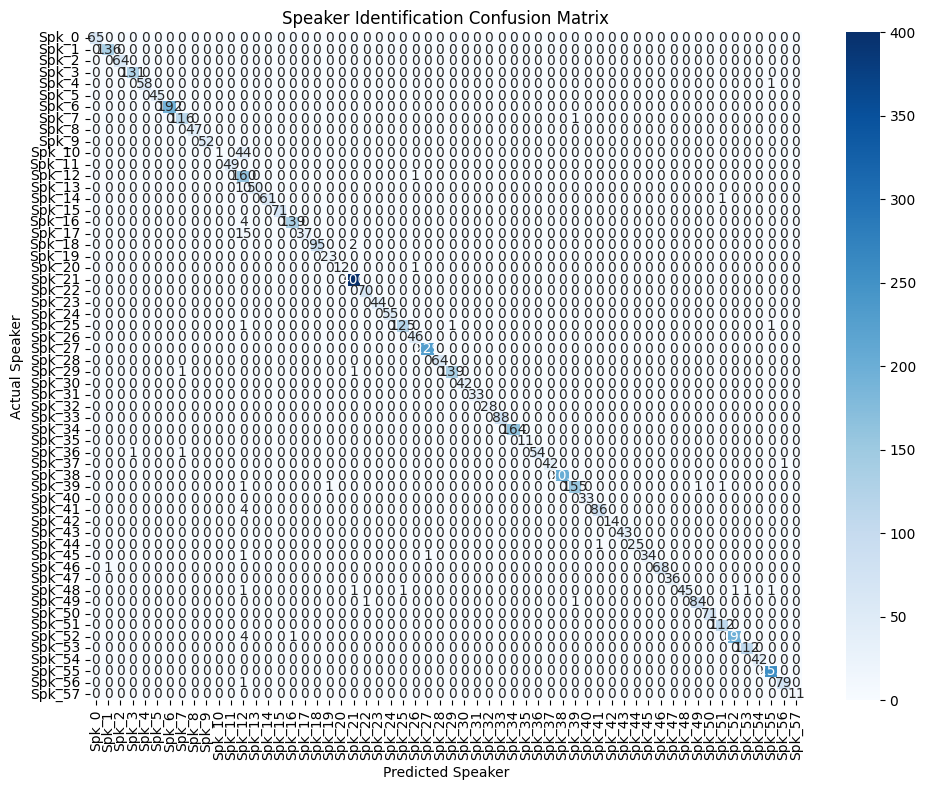



SPEAKER VERIFICATION TEST RESULTS

🎯 Verification Threshold: 0.7

📊 Speaker Identification Accuracy: 0.9775 (97.75%)
📊 Access Control Accuracy: 0.9923 (99.23%)

🔐 Access Control Confusion Matrix:
                      Predicted Access
                      Deny    Grant
  Actual Outsider  [  4314       0]
  Actual Member    [    39     703]

🔐 Access Control Metrics:
   True Positives (correctly granted): 703
   True Negatives (correctly denied):  4314
   False Positives (wrongly granted):  0
   False Negatives (wrongly denied):   39

   False Acceptance Rate (FAR): 0.0000 (0.00%)
   False Rejection Rate (FRR): 0.0526 (5.26%)
   Equal Error Rate (EER) ≈: 0.0263


In [76]:
# ============================================================================
# SECTION 6: RUN EVALUATION
# ============================================================================

# Clear CUDA cache
if torch.cuda.is_available():
    torch.cuda.empty_cache()
    torch.cuda.synchronize()

print("="*70)
print("🧪 RUNNING MODEL EVALUATION")
print("="*70)

# Auto-detect mode and run appropriate tests
label_mode = meta.get("label_mode", "speaker")
print(f"\n📋 Detected label_mode: '{label_mode}'")
print("-"*50)

results = test_model_auto(
    model,
    test_loader,
    meta=meta,
    threshold=0.7,  # Adjust as needed
    device=device
)

In [77]:
# Part 2: Speaker Verification / Access Control (for speaker mode only)
print("\n📋 PART 2: Speaker Verification (Access Control)")
print("-"*50)

label_mode = meta.get("label_mode", "speaker")

if label_mode == "binary":
    print("ℹ️ Binary mode detected - verification already tested above")
    print("   (Binary classification IS the access control decision)")
elif "speaker_mapping" in meta:
    ver_results = test_speaker_verification(
        model, 
        test_loader, 
        speaker_mapping=meta["speaker_mapping"],
        threshold=0.7,  # Adjust this threshold as needed
        device=device
    )
else:
    print("⚠️ No speaker_mapping in metadata - skipping verification test")


📋 PART 2: Speaker Verification (Access Control)
--------------------------------------------------
SPEAKER VERIFICATION TEST RESULTS

🎯 Verification Threshold: 0.7

📊 Speaker Identification Accuracy: 0.9775 (97.75%)
📊 Access Control Accuracy: 0.9923 (99.23%)

🔐 Access Control Confusion Matrix:
                      Predicted Access
                      Deny    Grant
  Actual Outsider  [  4314       0]
  Actual Member    [    39     703]

🔐 Access Control Metrics:
   True Positives (correctly granted): 703
   True Negatives (correctly denied):  4314
   False Positives (wrongly granted):  0
   False Negatives (wrongly denied):   39

   False Acceptance Rate (FAR): 0.0000 (0.00%)
   False Rejection Rate (FRR): 0.0526 (5.26%)
   Equal Error Rate (EER) ≈: 0.0263


## Section 7: Threshold Optimization (Optional)

Sweep through different thresholds to find the optimal operating point (EER).

In [78]:
# ============================================================================
# SECTION 7: THRESHOLD OPTIMIZATION (OPTIONAL)
# ============================================================================
# Uncomment and run this cell to find the optimal threshold

# print("\n📋 PART 3: Threshold Sweep")
# print("-"*50)
# 
# if "speaker_mapping" in meta:
#     sweep_results = test_threshold_sweep(
#         model, 
#         test_loader, 
#         speaker_mapping=meta["speaker_mapping"],
#         thresholds=np.arange(0.3, 0.95, 0.05),
#         device=device
#     )
# else:
#     print("⚠️ No speaker_mapping in metadata - skipping threshold sweep")

## 📚 Summary

### Supported Modes:

| Mode | Description | Classes |
|------|-------------|---------|
| **Binary** (`label_mode='binary'`) | Group member vs Outsider classification | 2 (outsider=0, member=1) |
| **Speaker ID** (`label_mode='speaker'`) | Individual speaker identification | N (one per speaker) |

### Evaluation Metrics Explained:

| Metric | Description |
|--------|-------------|
| **Speaker Identification Accuracy** | How often the model correctly identifies which speaker is talking |
| **Binary Classification Accuracy** | How often the model correctly classifies member vs outsider |
| **Access Control Accuracy** | How often the model correctly grants/denies access |
| **FAR (False Acceptance Rate)** | % of outsiders wrongly granted access (security risk) |
| **FRR (False Rejection Rate)** | % of authorized users wrongly denied access (usability issue) |
| **EER (Equal Error Rate)** | Threshold where FAR = FRR (lower is better) |

### Threshold Trade-off (Speaker ID mode):
- **Higher threshold** → Lower FAR (more secure), Higher FRR (more rejections)
- **Lower threshold** → Higher FAR (less secure), Lower FRR (fewer rejections)
- **Optimal**: Find the EER point or tune based on your security requirements

### Next Steps:
1. **If FRR is too high**: Lower the threshold or collect more training data for in-group speakers
2. **If FAR is too high**: Raise the threshold or add more diverse out-group speakers to training
3. **Export for deployment**: Use `export_onnx.ipynb` to export the model